# Progetto Big Data - Unipa

## Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve, roc_auc_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn import metrics
from multiprocessing import cpu_count
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt

## Data Load

In [2]:
df = pd.read_csv("../data/creditcard.csv")

y_class = df["Class"]

df = df.drop(columns= ["Class"])

In [3]:
profile = ProfileReport(df.sample(50000, random_state=42), title="Profiling Report", minimal=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/39 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Creazione dei dataset train e test

Per prima cosa, assegniamo alla variabile `X` i valori corrispondenti alla matrice delle feature, assegniamo alla variabile `y` il vettore delle classi da predire.

In [4]:
X = df.values
y = y_class.values

Dato che i valori di `y` non sono bilanciati, uno split semplice del dataset creerebbe due
sottodataset con frequenze di valori diverse per le classi da predire: 

In [5]:
np.random.seed(42)
y_rand = np.copy(y)
np.random.shuffle(y_rand)

y_rand_subset1 = y_rand[:100000]
y_rand_subset2 = y_rand[100000:]

print(f"""
      Dimensione y_rand_subset1: {y_rand_subset1.shape[0]}
      Dimensione y_rand_subset2: {y_rand_subset2.shape[0]}
""")


print(
    """
    ## DATASET y_rand_subset1 (Split semplice randomizzato)
    Frequenza relativa classe 0: {0:.2%}
    Frequenza relativa classe 1: {1:.2%}
    """.format(
        *pd.Series(y_rand_subset1).value_counts(normalize=1).values.tolist()
    )
)
print(
    """
    ## DATASET y_rand_subset2 (Split semplice randomizzato)
    Frequenza relativa classe 0: {0:.2%}
    Frequenza relativa classe 1: {1:.2%}
    """.format(
        *pd.Series(y_rand_subset2).value_counts(normalize=1).values.tolist()
    )
)


      Dimensione y_rand_subset1: 100000
      Dimensione y_rand_subset2: 184807


    ## DATASET y_rand_subset1 (Split semplice randomizzato)
    Frequenza relativa classe 0: 99.84%
    Frequenza relativa classe 1: 0.16%
    

    ## DATASET y_rand_subset2 (Split semplice randomizzato)
    Frequenza relativa classe 0: 99.82%
    Frequenza relativa classe 1: 0.18%
    


Data questa dinamica, utilizziamo lo `StratifiedShuffleSplit` di scikit-learn che permette di ottenere dei subset mantenendo equilibrata la classe obiettivo.

In [6]:
def shuffle_split_data(X: np.ndarray, y: np.ndarray):
    """Split di X e y per ottenere dataset di test e train con
    classi bilanciate.
    """
    sss0 = StratifiedShuffleSplit(
        n_splits=1,  # Eseguiamo una sola suddivisione
        test_size=.1,  # Recuperiamo un dataset di test = 10% delle osservaz.
        random_state=42  # Per mantenere la riproducibilità delle esecuzioni
    )
    train_index, test_index = list(sss0.split(X, y))[0]

    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = shuffle_split_data(X, y)

print(f"""
      Dimensione X_train:  {X_train.shape}
      Dimensione X_test: {X_test.shape}
      Dimensione y_train: {y_train.shape[0]}
      Dimensione y_test: {y_test.shape[0]}
""")

print(
    """
    ## DATASET TEST
    Frequenza relativa classe 0: {0:.2%}
    Frequenza relativa classe 1: {1:.2%}
    """.format(
        *pd.Series(y_test).value_counts(normalize=1).values.tolist()
    )
)
print(
    """
    ## DATASET TRAIN
    Frequenza relativa classe 0: {0:.2%}
    Frequenza relativa classe 1: {1:.2%}
    """.format(
        *pd.Series(y_train).value_counts(normalize=1).values.tolist()
    )
)


      Dimensione X_train:  (256326, 30)
      Dimensione X_test: (28481, 30)
      Dimensione y_train: 256326
      Dimensione y_test: 28481


    ## DATASET TEST
    Frequenza relativa classe 0: 99.83%
    Frequenza relativa classe 1: 0.17%
    

    ## DATASET TRAIN
    Frequenza relativa classe 0: 99.83%
    Frequenza relativa classe 1: 0.17%
    


## PreProcessing e selezione delle feature

1. Utilizzeremo `StandardScaler` per standardizzare le feature in modo da ottenere valori che abbiano media 0 e varianza 1. 
2. Utilizzeremo `SelectFromModel` per selezionare le feature maggiormente determinanti per la classificazione.
3. Utilizzeremo `RandomForestClassifier` come classificatore per predire il valore di `y`.

`SelectFromModel` utilizza un classificatore e analizza come il classificatore attribuisce peso alle features ai fini della classificazione finale, una volta individuate le feature maggiormente rilevanti modifica la matrice originaria eliminando le colonne corrispondenti.

In [7]:
feature_selector = Pipeline([
    ("scat_standard_scaling", StandardScaler()),
    ("feature_selection",
     SelectFromModel(ExtraTreesClassifier(n_estimators=50,
                                          n_jobs=-1,
                                          random_state=42,
                                          class_weight="balanced",
                                          verbose=1)))],
    verbose=1)

feature_selector

Pipeline(steps=[('scat_standard_scaling', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=ExtraTreesClassifier(class_weight='balanced',
                                                                n_estimators=50,
                                                                n_jobs=-1,
                                                                random_state=42,
                                                                verbose=1)))],
         verbose=1)

In [8]:
feature_selector.fit(X_train, y_train)

[Pipeline]  (step 1 of 2) Processing scat_standard_scaling, total=   0.2s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.7s


[Pipeline] . (step 2 of 2) Processing feature_selection, total=  10.1s


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.1s finished


Pipeline(steps=[('scat_standard_scaling', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=ExtraTreesClassifier(class_weight='balanced',
                                                                n_estimators=50,
                                                                n_jobs=-1,
                                                                random_state=42,
                                                                verbose=1)))],
         verbose=1)

A seguito del training, è possibile osservare come i differenti step di preprocessing abbiano eseguito lo scaling e la selezione delle features.

Scaler:

In [9]:
scaler = feature_selector.steps[0][1]

print("Componente:", scaler)

print("\n>>> Dopo il training, il parametro `mean_` dello scaler equivale"
      "\n>>> alla media del dataset")
print(np.mean(X_train, axis=0) == scaler.mean_)

print("\n>>> Dopo il training, il parametro `var_` dello scaler equivale"
      "\n>>> alla varianza del dataset")
print(np.var(X_train, axis=0) == scaler.var_)

X_train_scaled = scaler.transform(X_train)
print("\n>>> La media dei dati di training scalati equivale a 0.")
print(np.round(np.mean(X_train_scaled, axis=0), 4))
print("\n>>> La varianza dei dati di training scalati equivale a 1.")
print(np.var(X_train_scaled, axis=0))

Componente: StandardScaler()

>>> Dopo il training, il parametro `mean_` dello scaler equivale
>>> alla media del dataset
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]

>>> Dopo il training, il parametro `var_` dello scaler equivale
>>> alla varianza del dataset
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]

>>> La media dei dati di training scalati equivale a 0.
[-0.  0.  0.  0.  0.  0. -0.  0. -0.  0.  0.  0. -0. -0. -0.  0.  0.  0.
 -0. -0. -0.  0. -0. -0. -0.  0.  0. -0.  0.  0.]

>>> La varianza dei dati di training scalati equivale a 1.
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


**NOTA:** Questo serve per scalare in maniera omogenea anche i dati di test 
e quelli che il modello potrà incontrare in fase di inferenza.
Infatti, se i dati di test e di inferenza non venissero scalati con la stessa media
e varianza utilizzata in fase di training, i dati assumerebbero dei valori che potrebbero
divenire incomprensibili per il modello allenato su distribuzioni differenti.

#### Feature Selector:

Il componente feature selector ha selezionato le feature più rilevanti per la determinazione
del risultato finale (attraverso il calcolo di un indice di impurità basato sull'entropia
dei nodi che utilizzano feature nell'albero decisionale). Al fine di agevolare questa
fase, è stato utilizzato come base un modello `ExtraTreesClassifier`
(alberi decisionali randomizzati). 

SelectFromModel(estimator=ExtraTreesClassifier(class_weight='balanced',
                                               n_estimators=50, n_jobs=-1,
                                               random_state=42, verbose=1))
Features selezionate da SelectFromModel: Index(['V3', 'V4', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18'], dtype='object')


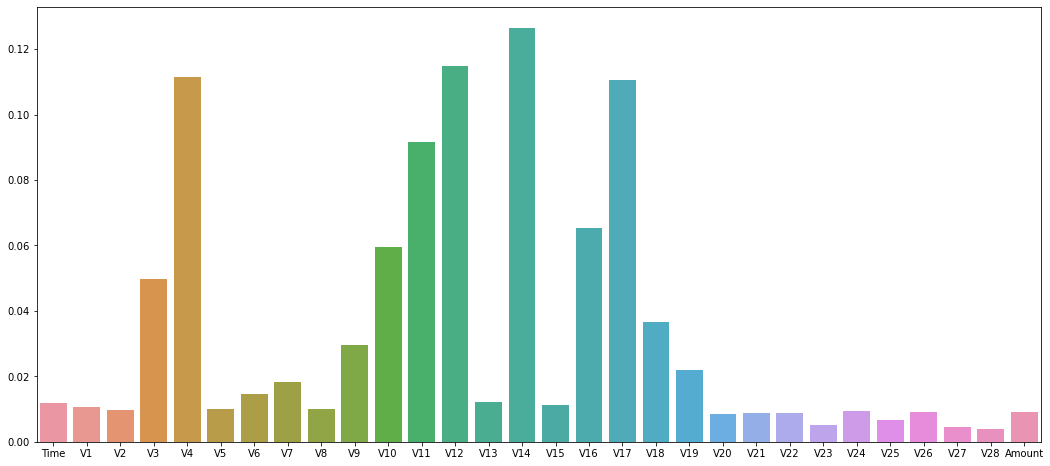

In [10]:
selector = feature_selector.steps[1][1]

print(selector)

feature_names = df.columns
selected_feature_names = feature_names[selector.get_support()]

print("Features selezionate da SelectFromModel: "
      f"{selected_feature_names}")

tree = selector.estimator_
feature_importances = tree.feature_importances_

fig, ax = plt.subplots(1, 1, figsize =(18,8))
g = sns.barplot(x = feature_names.values, y = feature_importances, ax = ax)

plt.show()

## Creazione della Pipeline di Classificazione

Una volta individuate le feature rilevanti, filtriamo il dataset in modo che contenga solo esse.
Inoltre, verrà creata una nuova pipeline `classifier` che non contiene il selettore delle
feature ma il solo classificatore finale (un modello Random Forest).

Eseguiremo quindi il fit della pipeline `classifier` con dei parametri rbitrari
per il classificatore, in modo da osservarne i risultati. 

In [11]:
X_sel = X[:, selector.get_support()]

X_train, X_test, y_train, y_test = shuffle_split_data(X_sel, y)

print(f"""
      Dimensione X_train:  {X_train.shape}
      Dimensione X_test: {X_test.shape}
      Dimensione y_train: {y_train.shape[0]}
      Dimensione y_test: {y_test.shape[0]}
""")

print(
    """
    ## DATASET TEST
    Frequenza relativa classe 0: {0:.2%}
    Frequenza relativa classe 1: {1:.2%}
    """.format(
        *pd.Series(y_test).value_counts(normalize=1).values.tolist()
    )
)
print(
    """
    ## DATASET TRAIN
    Frequenza relativa classe 0: {0:.2%}
    Frequenza relativa classe 1: {1:.2%}
    """.format(
        *pd.Series(y_train).value_counts(normalize=1).values.tolist()
    )
)


      Dimensione X_train:  (256326, 9)
      Dimensione X_test: (28481, 9)
      Dimensione y_train: 256326
      Dimensione y_test: 28481


    ## DATASET TEST
    Frequenza relativa classe 0: 99.83%
    Frequenza relativa classe 1: 0.17%
    

    ## DATASET TRAIN
    Frequenza relativa classe 0: 99.83%
    Frequenza relativa classe 1: 0.17%
    


In [12]:
classifier = Pipeline([
    ("scat_standard_scaling", StandardScaler()),
    ("classifier",
     RandomForestClassifier(n_estimators=10,
                            n_jobs=cpu_count() -1,
                            random_state=42,
                            class_weight="balanced",
                            verbose=0))],
    verbose=1)

classifier

Pipeline(steps=[('scat_standard_scaling', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=10, n_jobs=11,
                                        random_state=42))],
         verbose=1)

In [13]:
classifier.fit(X_train, y_train)

[Pipeline]  (step 1 of 2) Processing scat_standard_scaling, total=   0.1s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   1.8s


Pipeline(steps=[('scat_standard_scaling', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=10, n_jobs=11,
                                        random_state=42))],
         verbose=1)

## Valutazione del Modello

Example Predictions:

In [14]:
Y = classifier.predict(X_train)
Y.shape

(256326,)

Costruzione score:

In [15]:
def weighted_auc(y_true, y_score):
    # Distribuzione di frequenza delle classi
    sample_weight = pd.Series(y_true).value_counts(normalize=True)
    # Inverso della frequenza
    sample_weight = sample_weight.apply(lambda x: 1-x)
    # Creazione di un array con un numero di record pari a `y_true`
    # che contiene per ogni classe la relativa freq. inversa
    sample_weight = sample_weight.reindex(y_train)

    return roc_auc_score(y_true=y_true, y_score=y_score, sample_weight=sample_weight)

def reverse_weighted_auc(y_true, y_score):
    return 1 - weighted_auc(y_true, y_score)

weighted_auc(y_true=Y, y_score=y_train)

0.9752212422224751

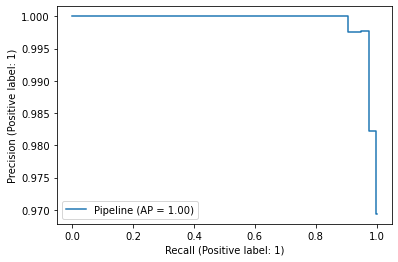

In [16]:
disp = plot_precision_recall_curve(classifier , X_train, y_train)

Per un ulteriore livello di dettaglio, si riportano i valori di precision e recall f1_score per il modello di classificazione

In [17]:
print(metrics.classification_report(y_true=y_train, y_pred=Y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    255883
           1       1.00      0.95      0.97       443

    accuracy                           1.00    256326
   macro avg       1.00      0.98      0.99    256326
weighted avg       1.00      1.00      1.00    256326



Dato il forte sbilanciamento delle classi è necessario ponderare le stesse al fine di ottenere un f1_score che tenga questo effetto in conto

In [18]:
sample_weight = pd.Series(y_train).value_counts(normalize=True).apply(lambda x:1-x).reindex(y_train)

print(metrics.classification_report(y_true=y_train, y_pred=Y, sample_weight=sample_weight))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98 442.23437731820246
           1       1.00      0.95      0.97 442.234377316383

    accuracy                           0.98 884.4687546345855
   macro avg       0.98      0.98      0.98 884.4687546345855
weighted avg       0.98      0.98      0.98 884.4687546345855



## Ottimizzazione dei parametri della pipeline

In questa prima esecuzione i parametri del classificatore utilizzati nella pipeline sono stati forniti in maniera arbitraria. Al fine di recuperare la migliore configurazione possibile per il classificatore, è possibile utilizzare una modalità di auto-ML attraverso una ricerca iterativa incrociata dei parametri ottimali per il modello.

Come obiettivo dell'ottimizzatore è stata fornita una funzione che cerca di massimizzare l'AUC (Nel nostro caso, la funzione `score_auc` restituisce il valore `1-auc`, da minimizzare).

In [19]:
model_scorer = metrics.make_scorer(roc_auc_score, greater_is_better=True)
# Cross-validation score

In [20]:
param_grid = {
    "classifier__n_estimators": [5, 10, 15, 20],
}
search = GridSearchCV(
    classifier,
    param_grid=param_grid,
    n_jobs=1,
    verbose=1,
    scoring=model_scorer,
    cv=StratifiedShuffleSplit(
        n_splits=3,  # Eseguiamo una sola suddivisione
        random_state=42  # Per mantenere la riproducibilità delle esecuzioni
    )
)
search.fit(X_train, y_train)

print(search.best_score_)
print(search.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[Pipeline]  (step 1 of 2) Processing scat_standard_scaling, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   1.8s
[Pipeline]  (step 1 of 2) Processing scat_standard_scaling, total=   0.1s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   1.4s
[Pipeline]  (step 1 of 2) Processing scat_standard_scaling, total=   0.1s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   1.1s
[Pipeline]  (step 1 of 2) Processing scat_standard_scaling, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   1.7s
[Pipeline]  (step 1 of 2) Processing scat_standard_scaling, total=   0.1s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   1.5s
[Pipeline]  (step 1 of 2) Processing scat_standard_scaling, total=   0.1s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   1.5s
[Pipeline]  (step 1 of 2) Processing scat_standard_scaling, total=   0

In [21]:
search.cv_results_

{'mean_fit_time': array([1.49897536, 1.62758581, 2.48775347, 3.06225022]),
 'std_fit_time': array([0.29588164, 0.07117767, 0.06734707, 0.05128179]),
 'mean_score_time': array([0.02614856, 0.01796985, 0.03553851, 0.04517396]),
 'std_score_time': array([0.00667898, 0.00104601, 0.00779467, 0.0029927 ]),
 'param_classifier__n_estimators': masked_array(data=[5, 10, 15, 20],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'classifier__n_estimators': 5},
  {'classifier__n_estimators': 10},
  {'classifier__n_estimators': 15},
  {'classifier__n_estimators': 20}],
 'split0_test_score': array([0.89768819, 0.88632456, 0.89766865, 0.89766865]),
 'split1_test_score': array([0.89770773, 0.8863441 , 0.90907137, 0.89770773]),
 'split2_test_score': array([0.81814274, 0.81814274, 0.86359728, 0.85223365]),
 'mean_test_score': array([0.87117956, 0.8636038 , 0.89011244, 0.88253668]),
 'std_test_score': array([0.03750269, 0.03214582, 0.0193183

## Test del classificatore

Metrica AUC: 0.9855
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.97      0.69      0.81        49

    accuracy                           1.00     28481
   macro avg       0.99      0.85      0.90     28481
weighted avg       1.00      1.00      1.00     28481



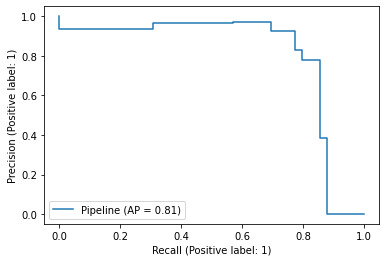

In [22]:
Y_test = classifier.predict(X_test)
disp_test = plot_precision_recall_curve(classifier , X_test, y_test)

print("Metrica AUC: {:.4f}".format(roc_auc_score(Y_test, y_test)))
print(metrics.classification_report(y_true=y_test, y_pred=Y_test))

Metrica AUC: 0.9866
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.97      0.76      0.85        49

    accuracy                           1.00     28481
   macro avg       0.99      0.88      0.93     28481
weighted avg       1.00      1.00      1.00     28481



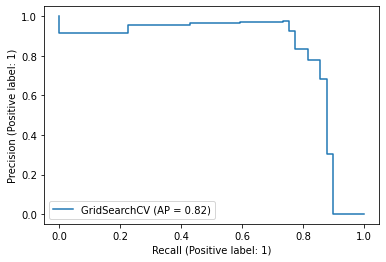

In [23]:
Y_test_search = search.predict(X_test)
disp_test_search = plot_precision_recall_curve(search , X_test, y_test)

print("Metrica AUC: {:.4f}".format(roc_auc_score(Y_test_search, y_test)))
print(metrics.classification_report(y_true=y_test, y_pred=Y_test_search))

## Conclusioni

Attraverso la ricerca incrociata dei parametri del classificatore è stato possibile migliorare i risultati del modello riducendo l'AUC e l' f1-score.

Nel caso specifico del business case in oggetto, è possibile osservare come si sia ottenuta una precisione del 100% sui casi di frode, con una recall del 76%. Di contro, con una strategia di traning aggressiva sul bilanciamento delle classi, la precision  